# Transformer Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
from sklearn.preprocessing import MinMaxScaler

In [3]:
df=pd.read_csv('preprocessed_data.csv')

In [4]:
df.columns = df.columns.str.strip()

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
label_encoder = LabelEncoder()

In [7]:
df['Company_encoded'] = label_encoder.fit_transform(df['Company'])

In [8]:
features=df.drop(columns=['Company', 'Target 1', 'Target 2', 'Target 3'])

In [9]:
y = df['Target 1'].values

In [10]:
features.head()

,Year,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature20,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Company_encoded
0,0.0,0.042740,1.000000,1.000000,0.816058,0.991490,1.000000,0.504032,1.0,0.394231,...,1.000000,1.000000,1.000000,1.000000,0.992685,1.000000,1.000000,0.515697,0.042114,1001
1,0.0,0.188153,0.915748,0.824484,0.775630,0.859654,0.000000,0.482527,1.0,0.394231,...,0.953115,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.647404,0.199529,1077
2,0.0,0.225219,0.824896,1.000000,1.000000,1.000000,1.000000,0.762097,1.0,0.432692,...,0.434449,0.500446,1.000000,0.487784,0.463120,0.454463,0.475678,0.418494,0.044785,2748
3,0.0,0.105467,0.458576,0.447087,0.375252,0.397321,0.487660,0.649194,1.0,0.394231,...,1.000000,1.000000,0.355742,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1711
4,0.0,0.422222,0.175416,0.231748,0.599227,0.290737,0.526773,0.462332,1.0,0.394231,...,0.356158,0.361839,0.621761,0.354119,0.350489,0.353435,0.360627,0.656372,1.000000,1413


In [11]:
train_size = int(0.8 * len(features))

X_train = features[:train_size]
X_test = features[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

print("Training set has {} samples.".format(len(X_train)))
print("Test set has {} samples.".format(len(X_test)))

Training set has 19800 samples.
Test set has 4951 samples.


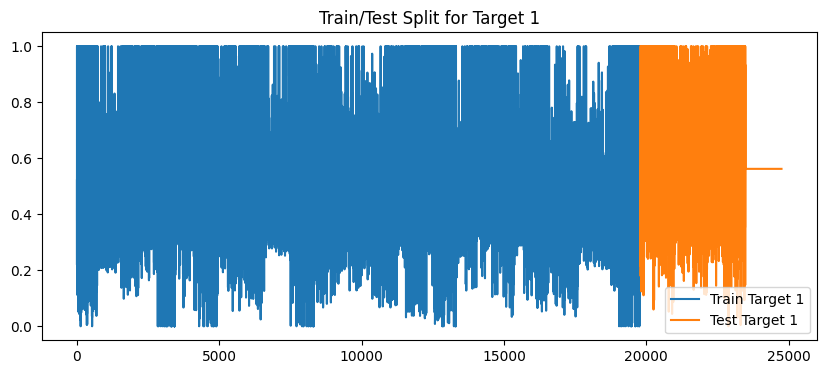

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_train, label='Train Target 1')
plt.plot(range(train_size, len(y)), y_test, label='Test Target 1')
plt.legend()
plt.title('Train/Test Split for Target 1')
plt.show()

In [13]:
def to_sequences(seq_size, X_data, y_data):
    x_seq = []
    y_seq = []

    for i in range(len(X_data) - seq_size):
        x_seq.append(X_data[i:i+seq_size])
        y_seq.append(y_data[i+seq_size])

    return np.array(x_seq), np.array(y_seq)

In [15]:
SEQUENCE_SIZE = 30

# Create sequences
x_train_seq, y_train_seq = to_sequences(SEQUENCE_SIZE, X_train, y_train)
x_test_seq, y_test_seq = to_sequences(SEQUENCE_SIZE, X_test, y_test)

# Shapes
print("✅ Shape of x_train_seq:", x_train_seq.shape)  # (num_samples, seq_len, num_features)
print("✅ Shape of y_train_seq:", y_train_seq.shape)
print("✅ Shape of x_test_seq:", x_test_seq.shape)
print("✅ Shape of y_test_seq:", y_test_seq.shape)

✅ Shape of x_train_seq: (19770, 30, 30)
✅ Shape of y_train_seq: (19770,)
✅ Shape of x_test_seq: (4921, 30, 30)
✅ Shape of y_test_seq: (4921,)


In [16]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, callbacks

In [17]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [18]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

In [19]:
input_shape = x_train_seq.shape[1:]
model = build_model(
    input_shape,
    head_size=512,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [23]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

In [24]:
callbacks_list = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [25]:
history = model.fit(
    x_train_seq,
    y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=callbacks_list,
)

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - loss: 706.1185 - val_loss: 80.6267
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 197.9861 - val_loss: 37.4978
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 140.4807 - val_loss: 22.8615
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 98.4233 - val_loss: 3.5591
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 18.2288 - val_loss: 1.7335
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 9.6358 - val_loss: 0.8066
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 6.9796 - val_loss: 0.5462
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 5.3048 - val_loss: 0.4144
Epoch 9/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 4.1643 - val_loss: 0.3196
Epoch 10/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 3.4986 - val_loss: 0.2657
Epoch 11/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 2.9624 - val_loss: 0.2141
Epoch 12/50
248/248 ━━━

In [26]:
test_loss = model.evaluate(x_test_seq, y_test_seq, verbose=1)
print(f"Test Loss: {test_loss}")

154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0526
Test Loss: 0.044603392481803894


In [27]:
def calculate_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
        "MAPE": metrics.mean_absolute_percentage_error(y_true, y_pred) * 100,
        "MAE": metrics.mean_absolute_error(y_true, y_pred),
        "MSE": metrics.mean_squared_error(y_true, y_pred),
        "sMAPE": smape(y_true, y_pred),
        "RRMSE": np.sqrt(metrics.mean_squared_error(y_true, y_pred)) / np.mean(y_true) * 100,
        "Quantile Loss": np.mean(quantile_loss(0.5, y_true, y_pred))
    }

In [29]:
pred_test = model.predict(x_test_seq)

154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step


In [30]:
# Print metrics for test set
metrics_dict_test = calculate_metrics(y_test_seq, pred_test)
print("\nTest Set Metrics:")
for metric_name, metric_value in metrics_dict_test.items():
    print(f"Score ({metric_name}): {metric_value}")


Test Set Metrics:
Score (RMSE): 0.2111951418849701
Score (MAPE): 43925725770339.02
Score (MAE): 0.15609081560655227
Score (MSE): 0.04460338795581265
Score (sMAPE): 137588.56348842688
Score (RRMSE): 36.998845821310745
Score (Quantile Loss): 0.07766465210621516


In [33]:
def plot_actual_vs_predicted(y_true, y_pred, filename):
    plt.figure(dpi=600)
    plt.plot(y_true, label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted', color='red', linewidth=2, linestyle='--')
    plt.legend(fontsize='medium', loc='upper left')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.title('Actual vs Predicted', fontsize=16, fontweight='bold')
    plt.savefig(filename, format='jpeg', dpi=600)
    plt.show()

In [34]:
def plot_loss(history, filename):
    plt.figure(dpi=600)
    plt.plot(history.history['loss'], label='Training Loss', color='g', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='b', linewidth=2)
    plt.legend(fontsize='medium', loc='upper right')
    plt.xlabel('Epochs', fontsize=16, fontweight='bold')
    plt.ylabel('Loss', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
    plt.savefig(filename, format='jpeg', dpi=600)
    plt.show()

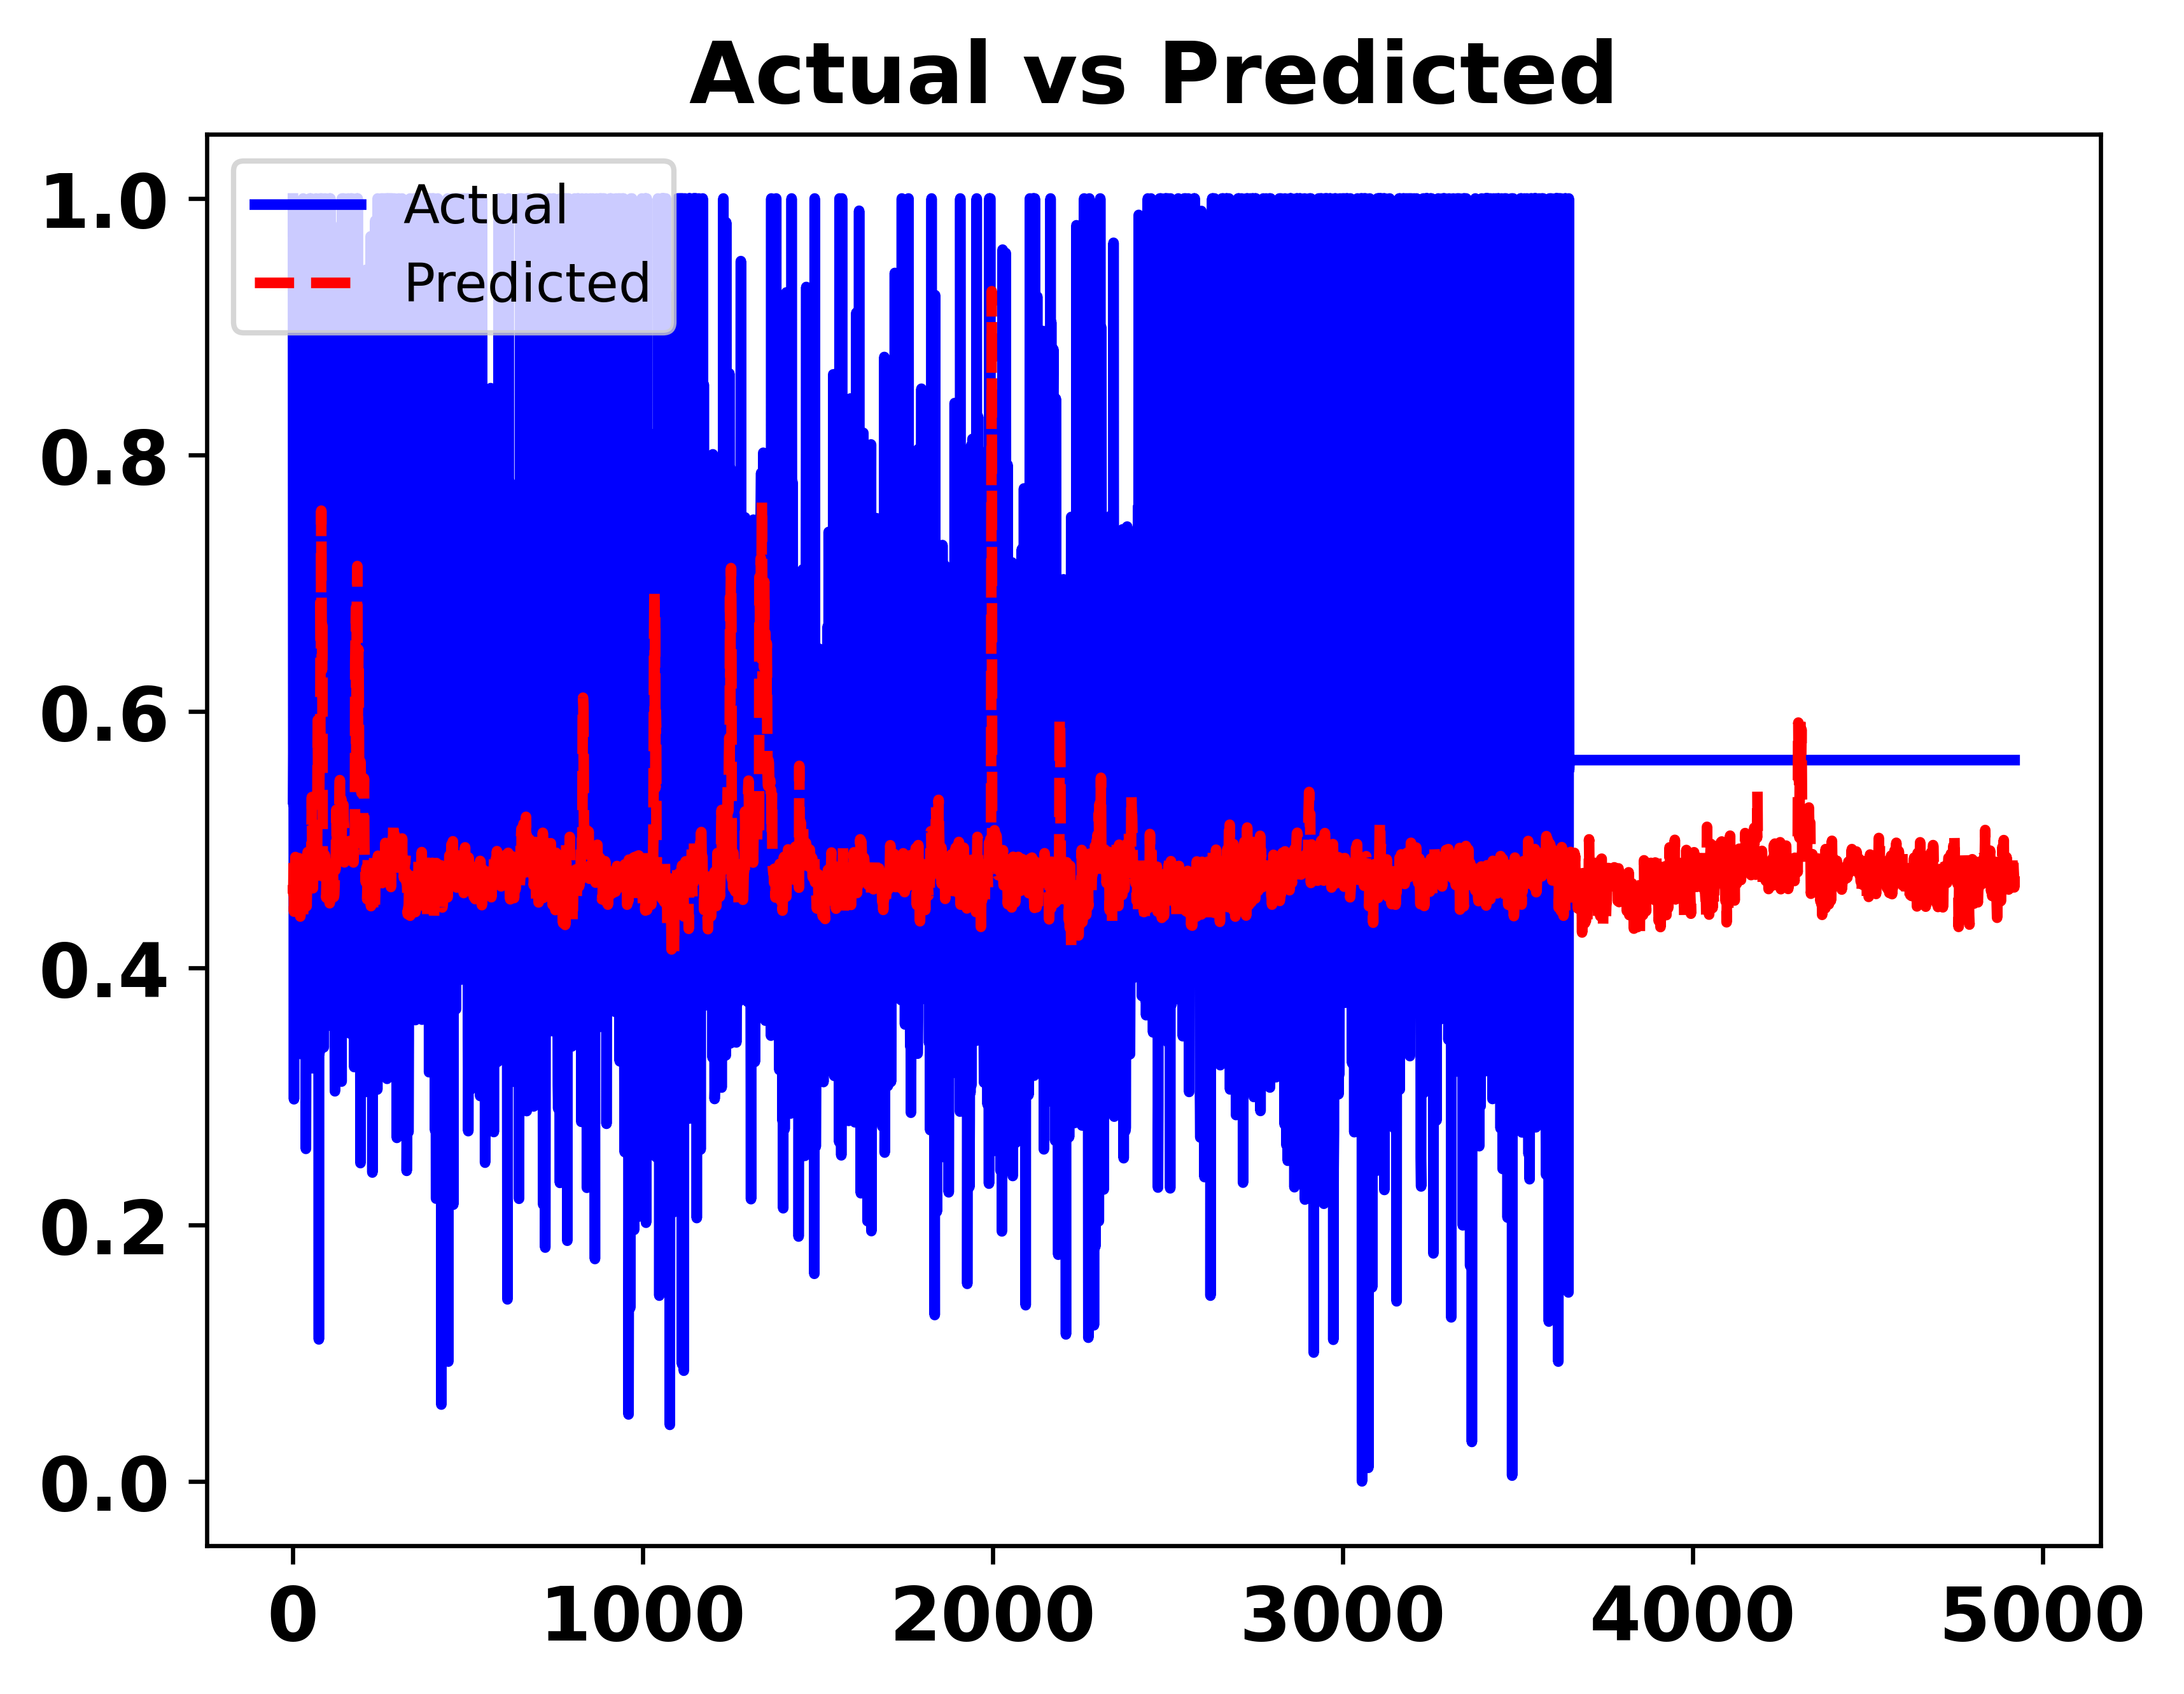

In [35]:
plot_actual_vs_predicted(y_test_seq, pred_test, 'Transformer_predicted_vs_actual.jpeg')

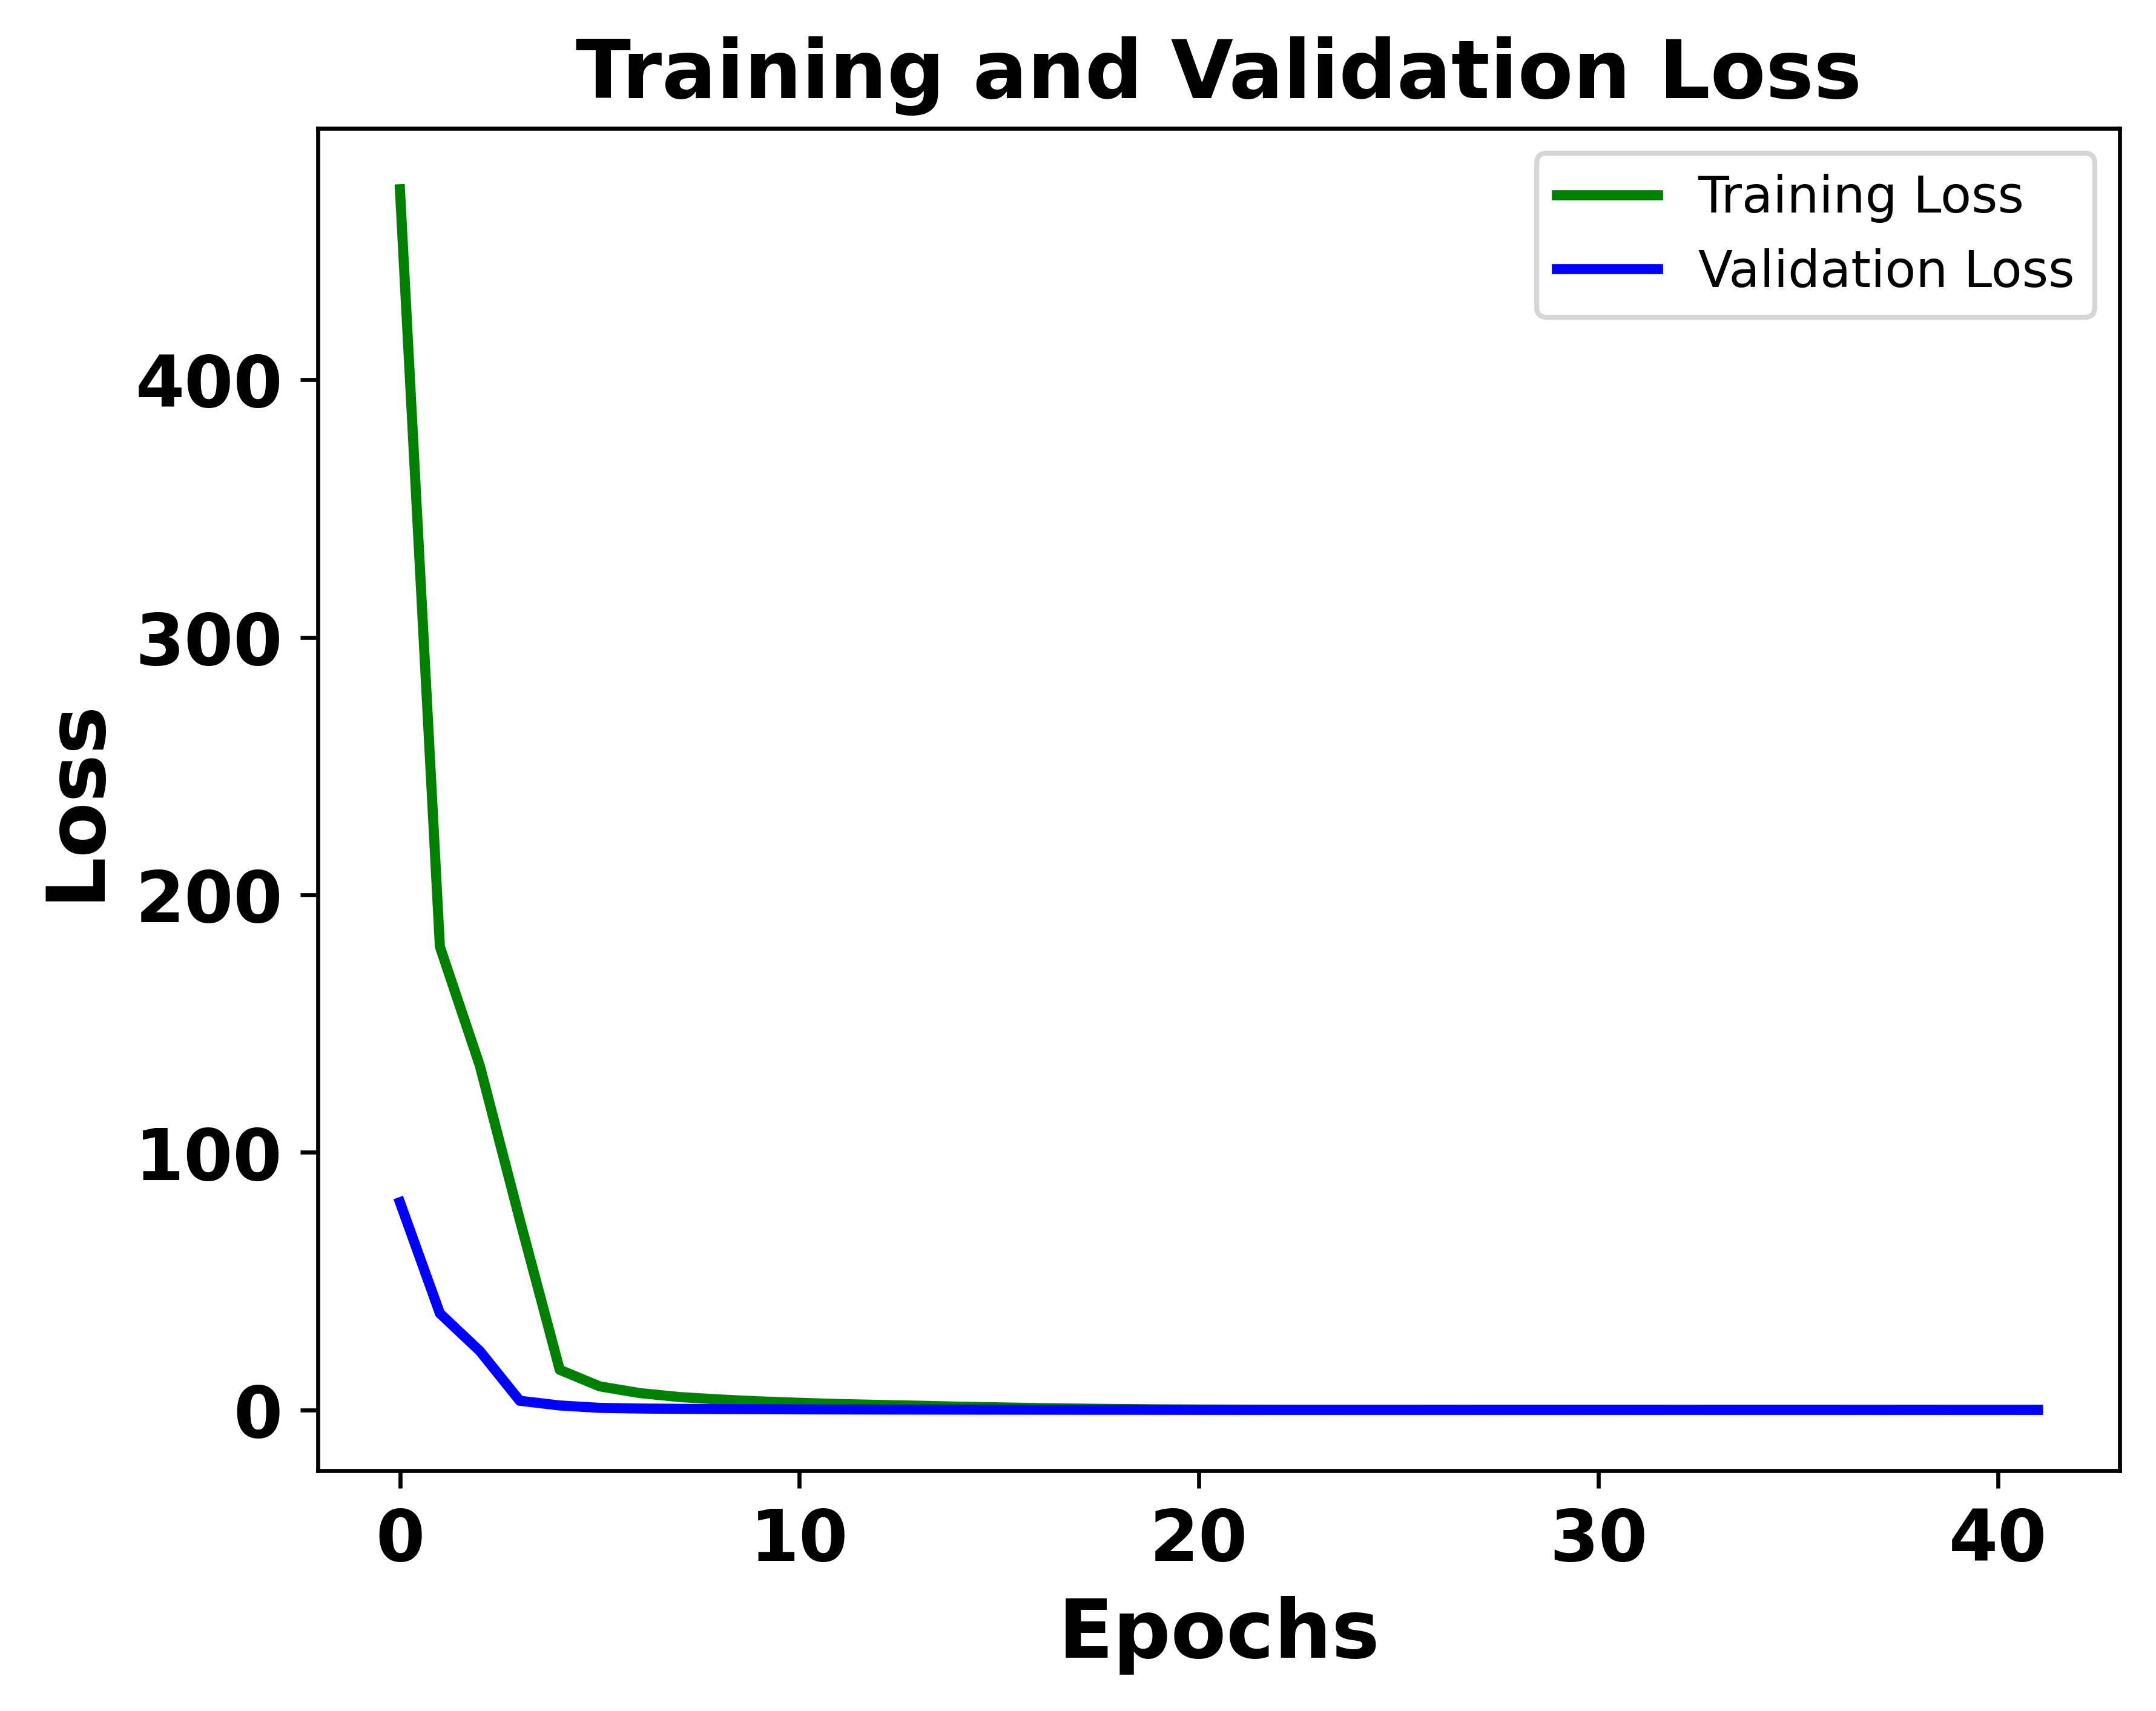

In [36]:
plot_loss(history, 'Transformer_loss_plot.jpeg')

In [37]:
from sklearn.metrics import mean_squared_error

# Compute Mean Squared Error
mse = mean_squared_error(y_test_seq, pred_test)

# Compute RMSE manually
rmse = np.sqrt(mse)

# Compute RMSE as a percentage of the mean of the actual values
rmse_percentage = (rmse / np.mean(y_test_seq)) * 100

print(f"RMSE for {'Target 1'} as a percentage: {rmse_percentage:.2f}%")

RMSE for Target 1 as a percentage: 37.00%


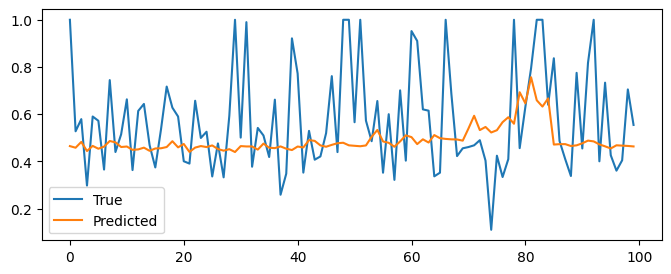

In [38]:
plt.figure(figsize=(8, 3))
plt.plot(y_test_seq[:100], label='True')
plt.plot(pred_test[:100], label='Predicted')
plt.legend()
plt.show()

# For Target-2

In [39]:
y = df['Target 2'].values

In [40]:
train_size = int(0.8 * len(features))

X_train = features[:train_size]
X_test = features[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

print("Training set has {} samples.".format(len(X_train)))
print("Test set has {} samples.".format(len(X_test)))

Training set has 19800 samples.
Test set has 4951 samples.


In [41]:
SEQUENCE_SIZE = 30

x_train_seq, y_train_seq = to_sequences(SEQUENCE_SIZE, X_train, y_train)
x_test_seq, y_test_seq = to_sequences(SEQUENCE_SIZE, X_test, y_test)

# Shapes
print("✅ Shape of x_train_seq:", x_train_seq.shape)  # (num_samples, seq_len, num_features)
print("✅ Shape of y_train_seq:", y_train_seq.shape)  # (num_samples,)
print("✅ Shape of x_test_seq:", x_test_seq.shape)
print("✅ Shape of y_test_seq:", y_test_seq.shape)

✅ Shape of x_train_seq: (19770, 30, 30)
✅ Shape of y_train_seq: (19770,)
✅ Shape of x_test_seq: (4921, 30, 30)
✅ Shape of y_test_seq: (4921,)


In [42]:
input_shape = x_train_seq.shape[1:]
model = build_model(
    input_shape,
    head_size=512,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [43]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

In [44]:
callbacks_list = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [45]:
history = model.fit(
    x_train_seq,
    y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=callbacks_list,
)

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 641.6310 - val_loss: 70.5352
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 208.4296 - val_loss: 37.7123
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 162.1257 - val_loss: 12.1570
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 41.8033 - val_loss: 2.5377
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 16.3088 - val_loss: 1.1211
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 10.2536 - val_loss: 0.7211
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 8.4113 - val_loss: 0.5773
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 7.0618 - val_loss: 0.4450
Epoch 9/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 6.2097 - val_loss: 0.3724
Epoch 10/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 5.1295 - val_loss: 0.2937
Epoch 11/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 4.4895 - val_loss: 0.2431
Epoch 12/50
248/248 ━

In [46]:
pred_test = model.predict(x_test_seq)

154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


In [47]:
from sklearn.metrics import mean_squared_error

# Compute Mean Squared Error
mse = mean_squared_error(y_test_seq, pred_test)

# Compute RMSE manually
rmse = np.sqrt(mse)

# Compute RMSE as a percentage of the mean of the actual values
rmse_percentage = (rmse / np.mean(y_test_seq)) * 100

print(f"📊 RMSE for {'Target 2'} as a percentage: {rmse_percentage:.2f}%")

📊 RMSE for Target 2 as a percentage: 30.20%


# Target-3

In [ ]:
y = df['Target 3'].values

In [ ]:
train_size = int(0.8 * len(features))

X_train = features[:train_size]
X_test = features[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

print("Training set has {} samples.".format(len(X_train)))
print("Test set has {} samples.".format(len(X_test)))

Training set has 19800 samples.
Test set has 4951 samples.


In [ ]:
SEQUENCE_SIZE = 30

# Create sequences
x_train_seq, y_train_seq = to_sequences(SEQUENCE_SIZE, X_train, y_train)
x_test_seq, y_test_seq = to_sequences(SEQUENCE_SIZE, X_test, y_test)

# Shapes
print("✅ Shape of x_train_seq:", x_train_seq.shape)  # (num_samples, seq_len, num_features)
print("✅ Shape of y_train_seq:", y_train_seq.shape)  # (num_samples,)
print("✅ Shape of x_test_seq:", x_test_seq.shape)
print("✅ Shape of y_test_seq:", y_test_seq.shape)

✅ Shape of x_train_seq: (19770, 30, 30)
✅ Shape of y_train_seq: (19770,)
✅ Shape of x_test_seq: (4921, 30, 30)
✅ Shape of y_test_seq: (4921,)


In [ ]:
input_shape = x_train_seq.shape[1:]
model = build_model(
    input_shape,
    head_size=512,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [ ]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

In [ ]:
callbacks_list = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [ ]:
history = model.fit(
    x_train_seq,
    y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=callbacks_list,
)

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - loss: 658.9092 - val_loss: 89.5748
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 218.8369 - val_loss: 41.7664
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 159.1169 - val_loss: 21.0776
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 74.9015 - val_loss: 2.4738
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 17.8119 - val_loss: 1.3338
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 11.1778 - val_loss: 0.8184
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 8.4236 - val_loss: 0.5977
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 6.8287 - val_loss: 0.4507
Epoch 9/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 5.9149 - val_loss: 0.4165
Epoch 10/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 5.0995 - val_loss: 0.3661
Epoch 11/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 4.4387 - val_loss: 0.3039
Epoch 12/50
248/248 ━━━

In [ ]:
pred_test = model.predict(x_test_seq)

154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step


In [ ]:
from sklearn.metrics import mean_squared_error

# Compute Mean Squared Error
mse = mean_squared_error(y_test_seq, pred_test)

# Compute RMSE manually
rmse = np.sqrt(mse)

# Compute RMSE as a percentage of the mean of the actual values
rmse_percentage = (rmse / np.mean(y_test_seq)) * 100

print(f" RMSE for {'Target 3'} as a percentage: {rmse_percentage:.2f}%")

📊 RMSE for Target 3 as a percentage: 24.33%
